# SMYLE: Nino3.4 Check 
 - Check that Lead Month 1 Nino3.4 looks reasonable
 - data read based on template from daniel kennedy (djk2120@ucar.edu): https://github.com/djk2120/cesm-lens

In [1]:
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
import cartopy.crs as ccrs
import glob
import dask
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2020.12.0
dask.__version__

'2021.02.0'

## Create Dask Cluster

In [28]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

KeyError: 'death-timeout'

In [46]:
#dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

In [2]:
from ncar_jobqueue import NCARCluster 

In [26]:
import ncar_jobqueue

In [27]:
ncar_jobqueue.__version__

'2020.12.4'

In [3]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
proj = 'NCGD0011'
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = NCARCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project=proj,
#                     scheduler_options={"dashboard_address":":8787"},
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41271 instead
  http_address["port"], self.http_server.port


In [4]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

Client Scheduler: tcp://10.12.205.30:39295 Dashboard: https://jupyterhub.ucar.edu/dav/user/yeager/proxy/41271/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Data I/O functions:
 - you should run each of these cells and then proceed to START HERE
 - you should not need to edit these function
 - (unless you want to add some missing functionality)

In [34]:
def get_micro_members(micro):
    members = []
    for j in 1+np.arange(20):
        s = 'LE2-'+str(micro)+'.'+str(j).zfill(3)
        members.append(s)
    return members

In [35]:
def get_macro_members():
    members = []
    for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
        s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
        members.append(s)
    return members

In [4]:
get_micro_members(1251)

['LE2-1251.001',
 'LE2-1251.002',
 'LE2-1251.003',
 'LE2-1251.004',
 'LE2-1251.005',
 'LE2-1251.006',
 'LE2-1251.007',
 'LE2-1251.008',
 'LE2-1251.009',
 'LE2-1251.010',
 'LE2-1251.011',
 'LE2-1251.012',
 'LE2-1251.013',
 'LE2-1251.014',
 'LE2-1251.015',
 'LE2-1251.016',
 'LE2-1251.017',
 'LE2-1251.018',
 'LE2-1251.019',
 'LE2-1251.020']

In [6]:
file = 'b.e21.BSMYLE.f09_g17.1996-11.001/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1996-11.001.pop.h.TEMP.199611-199810.nc'

In [8]:
file.split('b.e21.BSMYLE.f09_g17.')

['',
 '1996-11.001/ocn/proc/tseries/month_1/',
 '1996-11.001.pop.h.TEMP.199611-199810.nc']

In [7]:
def file_dict(topdir,field,mem,stmon):
    ''' returns a dictionary of filepaths keyed by initialization year, 
    for a given field, ensemble member, and initialization month '''
    memstr = '{0:03d}'.format(mem)
    monstr = '{0:02d}'.format(stmon)
    filepaths = {}
    
    #build casename
    casebase = 'b.e21.BSMYLE.f09_g17.'
    ocn_monthly = 'ocn/proc/tseries/month_1/'
    casename = casebase+'????-'+monstr+'.'+memstr
    filetemp = topdir+casename+'/'+ocn_monthly+casename+'.pop.h.'+field+'.*.nc'
    #find all the relevant files
    files = glob.glob(filetemp)
        
    for file in files:
        #isolate initialization year from the file name
        ystr = file.split(casebase)[-1]
        y0 = int(ystr[0:4])
        filepaths[y0]=file
        
    return filepaths

In [20]:
filepaths = file_dict('/glade/campaign/cesm/development/espwg/SMYLE/archive/','SSH',1,11)

In [21]:
filepaths

{1979: '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1979-11.001/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1979-11.001.pop.h.SSH.197911-198110.nc',
 1958: '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1958-11.001/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1958-11.001.pop.h.SSH.195811-196010.nc',
 1983: '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1983-11.001/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1983-11.001.pop.h.SSH.198311-198510.nc',
 1959: '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1959-11.001/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1959-11.001.pop.h.SSH.195911-196110.nc',
 1971: '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1971-11.001/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1971-11.001.pop.h.SSH.197111-197310.nc',
 1961: '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1961-11.001/o

In [8]:
def all_files(datadir,ens,field,firstyear,lastyear,stmon):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)+1
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                filepaths = file_dict(datadir,field,ee,stmon)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file
        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [28]:
np.array(range(10)) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [22]:
files,ens = all_files('/glade/campaign/cesm/development/espwg/SMYLE/archive/',range(10),'SSH',1958,1997,11)

In [23]:
files[9]

['/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1958-11.010/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1958-11.010.pop.h.SSH.195811-196010.nc',
 '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1959-11.010/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1959-11.010.pop.h.SSH.195911-196110.nc',
 '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1960-11.010/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1960-11.010.pop.h.SSH.196011-196210.nc',
 '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1961-11.010/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1961-11.010.pop.h.SSH.196111-196310.nc',
 '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1962-11.010/ocn/proc/tseries/month_1/b.e21.BSMYLE.f09_g17.1962-11.010.pop.h.SSH.196211-196410.nc',
 '/glade/campaign/cesm/development/espwg/SMYLE/archive/b.e21.BSMYLE.f09_g17.1963-11.010/ocn/proc/tseries/month_1/b.e21.BSMYLE

In [24]:
def get_data(datadir,ens,field,firstyear,lastyear,stmon,chunks={'time':24}):
    ''' returns an xarray dataset containing the requested ensemble
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    firstyear = int [1850-1950]
    lastyear  = int [1850-1950] '''

    ds = xr.Dataset()    #instantiate Dataset
    yrs = np.arange(firstyear,lastyear+1)
    files,ens = all_files(datadir,ens,field,firstyear,lastyear,stmon)
    ensdim  = xr.DataArray(ens, dims='M', name='M')
    yeardim = xr.DataArray(yrs, dims='Y', name='Y')
    dims    = [ensdim,yeardim]
    # check if all members have the same number of files (not guaranteed)
    nfs = np.array([len(ffs) for ffs in files])
    if np.sum(nfs==nfs[0])==len(nfs):
        one_go=True   # same number of files
    else:
        one_go=False
    if one_go: #read all data in one go
        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=dims,chunks=chunks)
    else:      #read data one member at a time and then concat
        dsets = []
        for ffs in files:
            d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,
                                concat_dim=yeardim,chunks=chunks)
            dsets.append(d0)
        tmp = xr.concat(dsets,dim=ensdim)
    ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
#    tmp = xr.open_dataset(files[0][0])
#    for thisvar in tmp.data_vars:
#        if 'time' not in tmp[thisvar].coords:
#            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds

In [44]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

# Start of Main Processing:

In [18]:
%%time
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
ens = range(10)
firstyear = 1958
lastyear  = 1997
ds_ssh = get_data(datadir,ens,'SSH',firstyear,lastyear,11)
ds_ssh.nbytes/1e9 #GB

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.arr

CPU times: user 42.1 s, sys: 5.5 s, total: 47.6 s
Wall time: 2min 14s


96.751789224

In [19]:
ds_ssh

<xarray.Dataset>
Dimensions:                 (M: 10, Y: 40, moc_comp: 3, nlat: 384, nlon: 320, time: 492, transport_comp: 5, transport_reg: 2, z_t: 60, z_w: 60)
Coordinates:
  * time                    (time) object 1958-01-01 00:00:00 ... 1998-12-01 ...
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * M                       (M) int64 1 2 3 4 5 6 7 8 9 10
  * Y                       (Y) int64 1958 1959 1960 1961 ... 1995 1996 1997
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables:
    SSH                     (Y, M, time, nlat, nlon) float32 dask.array<chunksize=(1, 1, 492, 384, 320), meta=np.ndarray>
    moc_components          (moc_comp) |S384 ...
    transport_components    (transport_comp) |S384 ...
    transport_regions       (transport_reg) |S384 ...
    dz                      (z_t) float32 ...
    dzw                     (z_w) float32 ...
    KMT                     (nlat, nlon) float64 ...
    KMU                     (nlat, nlon) float64 ...
    REGION_MASK             (nlat, nlon) float64 ...
    UAREA                   (nlat, nlon) float64 ...
    TAREA                   (nlat, nlon) float64 ...
    HU                      (nlat, nlon) float64 ...
    HT                      (nlat, nlon) float64 ...
    DXU                     (nlat, nlon) float64 ...
    DYU                     (nlat, nlon) float64 ...
    DXT                     (nlat, nlon) float64 ...
    DYT                     (nlat, nlon) float64 ...
    HTN                     (nlat, nlon) float64 ...
    HTE                     (nlat, nlon) float64 ...
    HUS                     (nlat, nlon) float64 ...
    HUW                     (nlat, nlon) float64 ...
    ANGLE                   (nlat, nlon) float64 ...
    ANGLET                  (nlat, nlon) float64 ...
    days_in_norm_year       timedelta64[ns] ...
    grav                    float64 ...
    omega                   float64 ...
    radius                  float64 ...
    cp_sw                   float64 ...
    sound                   float64 ...
    vonkar                  float64 ...
    cp_air                  float64 ...
    rho_air                 float64 ...
    rho_sw                  float64 ...
    rho_fw                  float64 ...
    stefan_boltzmann        float64 ...
    latent_heat_vapor       float64 ...
    latent_heat_fusion      float64 ...
    latent_heat_fusion_mks  float64 ...
    ocn_ref_salinity        float64 ...
    sea_ice_salinity        float64 ...
    T0_Kelvin               float64 ...
    salt_to_ppt             float64 ...
    ppt_to_salt             float64 ...
    mass_to_Sv              float64 ...
    heat_to_PW              float64 ...
    salt_to_Svppt           float64 ...
    salt_to_mmday           float64 ...
    momentum_factor         float64 ...
    hflux_factor            float64 ...
    fwflux_factor           float64 ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...

In [55]:
%%time
datadir = '/glade/scratch/yeager/cesm2_le/'
ens = range(10)
casenum = 1231   # micro 1
firstyear = 1850
lastyear  = 1959
ds_micro1231 = get_data(datadir,ens,casenum,firstyear,lastyear,chunks={'time':120})
ds_micro1231.nbytes/1e9 #GB

CPU times: user 1.55 s, sys: 70.3 ms, total: 1.62 s
Wall time: 6.08 s


10.886846196

In [57]:
%%time
datadir = '/glade/scratch/yeager/cesm2_le/'
ens = range(10)
casenum = 1251   # micro 1
firstyear = 1850
lastyear  = 1959
ds_micro1251 = get_data(datadir,ens,casenum,firstyear,lastyear,chunks={'time':120})
ds_micro1251.nbytes/1e9 #GB

CPU times: user 1.44 s, sys: 91.6 ms, total: 1.53 s
Wall time: 8.3 s


10.886846196

In [58]:
%%time
datadir = '/glade/scratch/yeager/cesm2_le/'
ens = range(10)
casenum = 1281   # micro 1
firstyear = 1850
lastyear  = 1959
ds_micro1281 = get_data(datadir,ens,casenum,firstyear,lastyear,chunks={'time':120})
ds_micro1281.nbytes/1e9 #GB

CPU times: user 1.53 s, sys: 72.5 ms, total: 1.6 s
Wall time: 5.46 s


10.886846196

In [59]:
%%time
datadir = '/glade/scratch/yeager/cesm2_le/'
ens = range(10)
casenum = 1301   # micro 1
firstyear = 1850
lastyear  = 1959
ds_micro1301 = get_data(datadir,ens,casenum,firstyear,lastyear,chunks={'time':120})
ds_micro1301.nbytes/1e9 #GB

CPU times: user 1.34 s, sys: 76.5 ms, total: 1.41 s
Wall time: 5.63 s


10.886846196

In [74]:
ds_macro.moc_s

<xarray.DataArray 'moc_s' (moc_s: 87)>
array([27.9  , 28.1  , 28.3  , 28.5  , 28.7  , 28.9  , 29.1  , 29.3  , 29.5  ,
       29.7  , 29.9  , 30.1  , 30.3  , 30.5  , 30.7  , 30.9  , 31.1  , 31.3  ,
       31.5  , 31.7  , 31.9  , 32.1  , 32.3  , 32.5  , 32.7  , 32.9  , 33.1  ,
       33.3  , 33.5  , 33.7  , 33.9  , 34.1  , 34.3  , 34.5  , 34.7  , 34.9  ,
       35.05 , 35.15 , 35.25 , 35.35 , 35.45 , 35.55 , 35.65 , 35.75 , 35.85 ,
       35.95 , 36.025, 36.075, 36.125, 36.175, 36.225, 36.275, 36.325, 36.375,
       36.425, 36.475, 36.525, 36.575, 36.625, 36.675, 36.725, 36.775, 36.825,
       36.875, 36.925, 36.975, 37.025, 37.075, 37.125, 37.175, 37.225, 37.275,
       37.325, 37.375, 37.425, 37.475, 37.525, 37.575, 37.625, 37.675, 37.725,
       37.775, 37.825, 37.875, 37.925, 37.975, 38.025])
Coordinates:
  * moc_s    (moc_s) float64 27.9 28.1 28.3 28.5 ... 37.88 37.92 37.98 38.02
Attributes:
    long_name:  Sigma2 at top of layer
    units:      kg/m^3

# Plot Micro differences from Macro:

In [91]:
# 1850-1870
y0 = 1850
y1 = 1870
macro_mean = ds_macro.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
macro_std = ds_macro.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).std('time').mean('ens')
macro_mean = macro_mean.where(macro_std>0.2)

mean_1231 = ds_micro1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
mean_1251 = ds_micro1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
mean_1281 = ds_micro1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
mean_1301 = ds_micro1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')

anom_1231 = mean_1231 - macro_mean
anom_1251 = mean_1251 - macro_mean
anom_1281 = mean_1281 - macro_mean
anom_1301 = mean_1301 - macro_mean

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


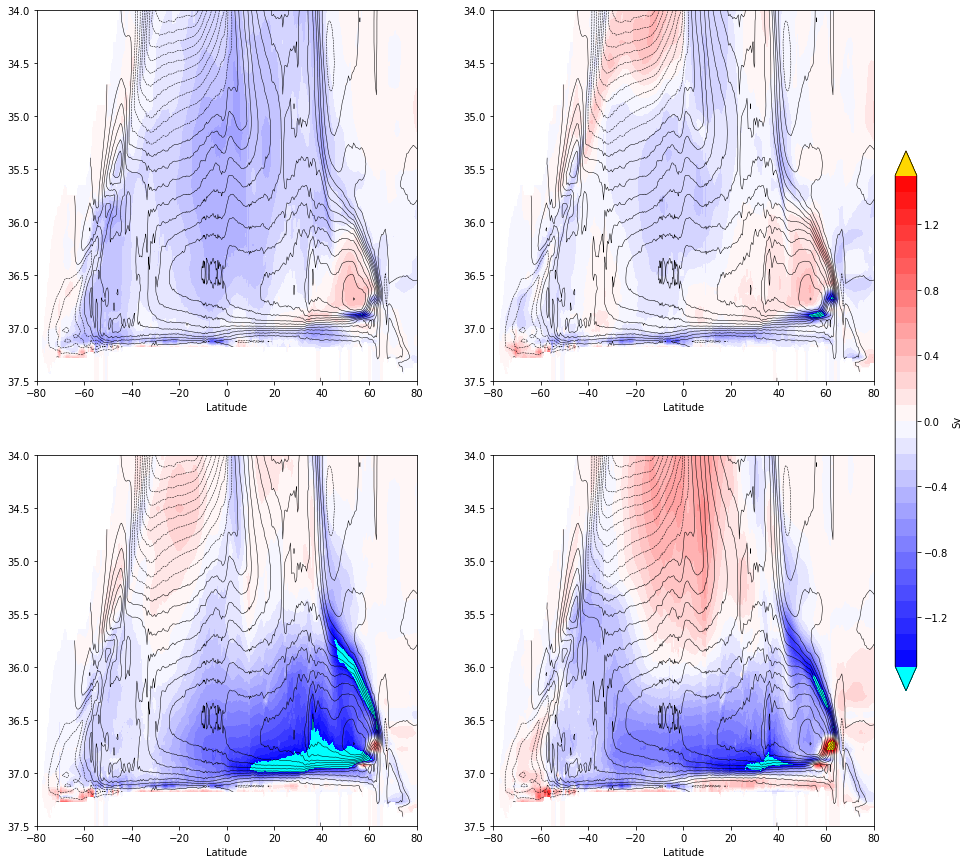

In [96]:
# MOC(Sigma)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

mnlevs = np.arange(0,31,1)*2. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]

fontsize=12

colmap = copy.copy(plt.cm.bwr)

cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
cntr1a.cmap.set_under('cyan')
cntr1a.cmap.set_over('gold')
ax1.set_ylim(37.5, 34.0)
ax1.set_xlim(-80, 80)
ax1.set_xlabel('Latitude')

cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
cntr2a.cmap.set_under('cyan')
cntr2a.cmap.set_over('gold')
ax2.set_ylim(37.5, 34.0)
ax2.set_xlim(-80, 80)
ax2.set_xlabel('Latitude')

cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
cntr3a.cmap.set_under('cyan')
cntr3a.cmap.set_over('gold')
ax3.set_ylim(37.5, 34.0)
ax3.set_xlim(-80, 80)
ax3.set_xlabel('Latitude')

cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
cntr4a.cmap.set_under('cyan')
cntr4a.cmap.set_over('gold')
ax4.set_ylim(37.5, 34.0)
ax4.set_xlim(-80, 80)
ax4.set_xlabel('Latitude')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')

In [102]:
np.arange(0,16,1)*4. - 30.

array([-30., -26., -22., -18., -14., -10.,  -6.,  -2.,   2.,   6.,  10.,
        14.,  18.,  22.,  26.,  30.])

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


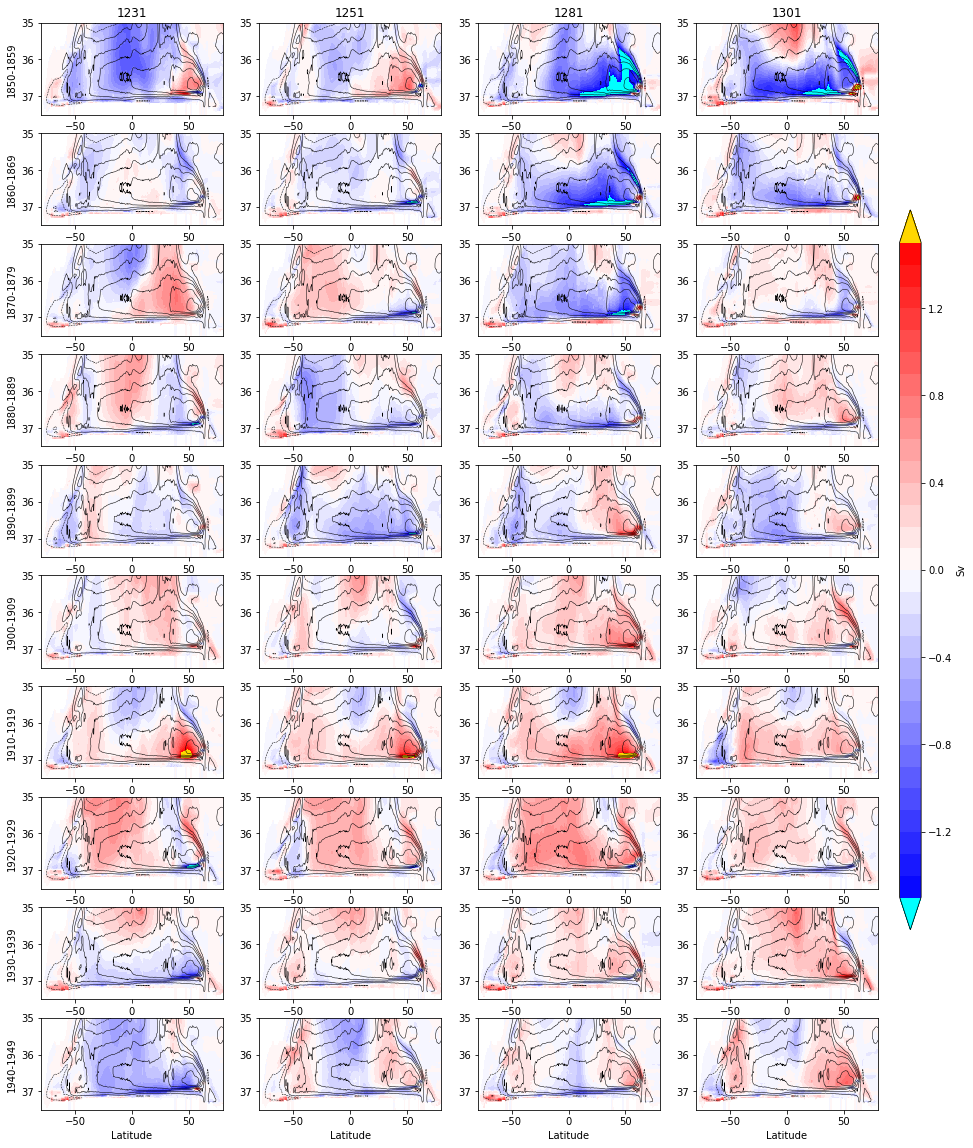

In [103]:
time0 = np.arange(1850,1950,10)
nrow = np.shape(time0)[0]
ncol = 4
fig = plt.figure(figsize=(15, 20))

#mnlevs = np.arange(0,31,1)*2. - 30.
mnlevs = np.arange(0,16,1)*4. - 30.
anlevs = np.arange(0,31,1)*0.1 - 1.5
yticks = [29,30,31,32,33,34,35,36,37,38]
colmap = copy.copy(plt.cm.bwr)
fontsize=12

for i in range(nrow):
    y0 = time0[i]
    y1 = y0+9
    timestamp = str(y0)+'-'+str(y1)
    macro_mean = ds_macro.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
    macro_mean = macro_mean.where(macro_std>0.2)
    mean_1231 = ds_micro1231.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
    mean_1251 = ds_micro1251.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
    mean_1281 = ds_micro1281.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
    mean_1301 = ds_micro1301.MOCsig.sel(time=slice(str(y0),str(y1))).sum('moc_comp').isel(transport_reg=0).mean('time').mean('ens')
    anom_1231 = mean_1231 - macro_mean
    anom_1251 = mean_1251 - macro_mean
    anom_1281 = mean_1281 - macro_mean
    anom_1301 = mean_1301 - macro_mean
    
    ax1 = fig.add_subplot(nrow,ncol,i*ncol+1)
    cntr1 = ax1.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr1a = ax1.contourf(anom_1231.lat_aux_grid, anom_1231.moc_s, anom_1231,levels=anlevs, cmap=colmap, extend='both')
    cntr1a.cmap.set_under('cyan')
    cntr1a.cmap.set_over('gold')
    ax1.set_ylim(37.5, 35.0)
    ax1.set_xlim(-80, 80)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel(timestamp)
    if i==0: ax1.set_title('1231', fontdict={'size':fontsize}, loc='center')
        
    ax2 = fig.add_subplot(nrow,ncol,i*ncol+2)
    cntr2 = ax2.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr2a = ax2.contourf(anom_1251.lat_aux_grid, anom_1251.moc_s, anom_1251,levels=anlevs, cmap=colmap, extend='both')
    cntr2a.cmap.set_under('cyan')
    cntr2a.cmap.set_over('gold')
    ax2.set_ylim(37.5, 35.0)
    ax2.set_xlim(-80, 80)
    ax2.set_xlabel('Latitude')
    if i==0: ax2.set_title('1251', fontdict={'size':fontsize}, loc='center')
        
    ax3 = fig.add_subplot(nrow,ncol,i*ncol+3)
    cntr3 = ax3.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr3a = ax3.contourf(anom_1281.lat_aux_grid, anom_1281.moc_s, anom_1281,levels=anlevs, cmap=colmap, extend='both')
    cntr3a.cmap.set_under('cyan')
    cntr3a.cmap.set_over('gold')
    ax3.set_ylim(37.5, 35.0)
    ax3.set_xlim(-80, 80)
    ax3.set_xlabel('Latitude')
    if i==0: ax3.set_title('1281', fontdict={'size':fontsize}, loc='center')
        
    ax4 = fig.add_subplot(nrow,ncol,i*ncol+4)
    cntr4 = ax4.contour(macro_mean.lat_aux_grid, macro_mean.moc_s, macro_mean,levels=mnlevs, linewidths=0.5, colors='k')
    cntr4a = ax4.contourf(anom_1301.lat_aux_grid, anom_1301.moc_s, anom_1301,levels=anlevs, cmap=colmap, extend='both')
    cntr4a.cmap.set_under('cyan')
    cntr4a.cmap.set_over('gold')
    ax4.set_ylim(37.5, 35.0)
    ax4.set_xlim(-80, 80)
    ax4.set_xlabel('Latitude')
    if i==0: ax4.set_title('1301', fontdict={'size':fontsize}, loc='center')
        
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(cntr1a, cax=cbar_ax, label='Sv', extend='both')